In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
!pip install pandas-profiling[notebook,html]

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install wordcloud

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
df =pd.read_json('reddit_jokes.json')

In [5]:
df.head()

,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


In [6]:
df = df[df.score > 0].reset_index()

In [7]:
df.shape

(132992, 5)

In [8]:
df['joke'] = df['title'] +'. '+ df['body']

In [9]:
df = df.loc[:,['joke','score']]

In [10]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [11]:
profile.to_notebook_iframe()

In [12]:
df.score.describe()

count    132992.000000
mean        172.947914
std        1128.187118
min           1.000000
25%           3.000000
50%           8.000000
75%          36.000000
max       48526.000000
Name: score, dtype: float64

It seems that the minimum score we can have is 1 and the maximum is 48526 but since the 75% is far from this value it seems like an outlier



In [13]:
df.score.quantile(0.99)

3932.2699999999895

(-2776.914347095068, 3932.2699999999895)

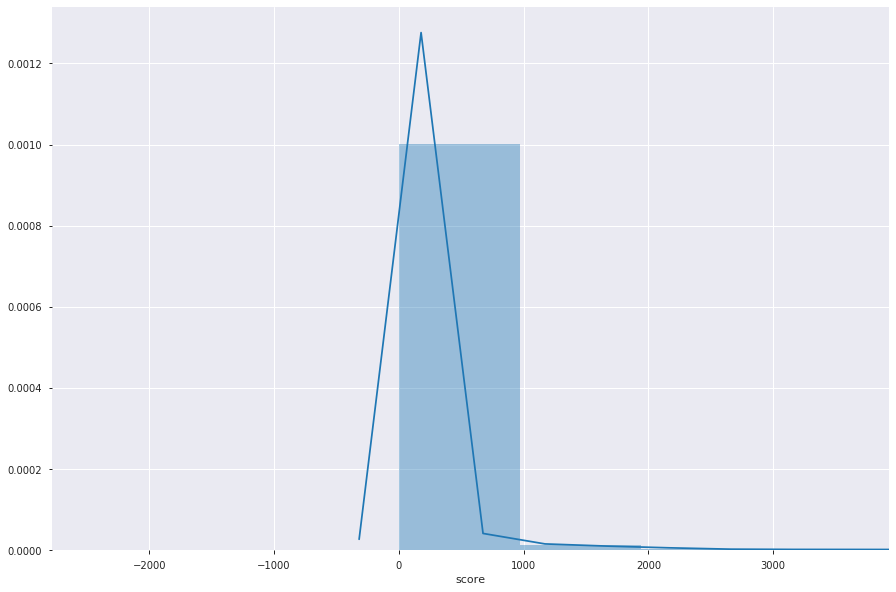

In [14]:
plt.figure(figsize=(15,10))
ax = sns.distplot(df.score)
ax.set_xlim(right=df.score.quantile(0.99))

In [15]:
df.score.quantile(0.86)

101.0

We can see that we have 86% of our score comprised between 1 and 101 and up to around 4000 for 99% 

In [ ]:
pal = sns.color_palette()
plt.figure(figsize=(15, 10))
plt.hist(df.joke.apply(len), bins=300, range=[0, 300], color=pal[2], density=True, label='Jokes')
plt.title('Normalised histogram of character count in Jokes', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean {:.2f} std {:.2f}  max {:.2f}'.format(df.joke.mean(), 
                          df.joke.std(), df.joke.max()))
plt.show()

In [ ]:
# All words 
cloud = WordCloud(width=1440, height=1080).generate(" ".join(df.joke.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
funniest_jokes = df[df.score >df.score.quantile(0.8)].joke

In [ ]:
# Funniest Jokes like the top 20% of jokes
cloud = WordCloud(width=1440, height=1080).generate(" ".join(funniest_jokes.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex """
    return len(re.findall(regexp, text))


def numerical_features(df):
    df['char_count'] = df.joke.apply(len)
    df['num_words'] = df.joke.apply(lambda comment: len(comment.split()))
    df['capitals'] = df.joke.apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['char_count']),
    axis=1)
    df['num_exclamation_marks'] = df.joke.apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df.joke.apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df.joke.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df["num_stopwords"] = df.joke.apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
    df['num_symbols'] = df.joke.apply(
    lambda comment: sum(comment.count(w) for w in '* &$%'))
    df['mean_word_len'] = df.joke.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['num_unique_words'] = df.joke.apply(
    lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df.joke.apply(
    lambda comment: sum(comment.count(w) for w in (': -)', ':)', '; -)', '; )')))
    # Count number of \n
    df["ant_slash_n"]=df.joke.apply(lambda x: count_regexp_occ(r"\n", x))
    # Check for time stamp
    df["has_timestamp"] = df.joke.apply(lambda x: count_regexp_occ(r"\d{2} | : \d{2}", x))
    # Check for http links
    df["has_http"]=df.joke.apply(lambda x: count_regexp_occ(r"http[s]{0, 1}: //\S +", x))
    return df

In [ ]:
df_stats = numerical_features(df.copy())

In [ ]:
df_stats.head().T

In [ ]:
def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

In [ ]:
for df_stats in ([df_stats]):
  df_stats['nouns'], df_stats['adjectives'], df_stats['verbs'] = zip(*df_stats.joke.apply(
  lambda comment: tag_part_of_speech(comment)))
  df_stats['nouns_vs_length'] = df_stats['nouns'] / df_stats['char_count']
  df_stats['adjectives_vs_length'] = df_stats['adjectives'] / df_stats['char_count']
  df_stats['verbs_vs_length'] = df_stats['verbs'] /df_stats['char_count']
  df_stats['nouns_vs_words'] = df_stats['nouns'] / df_stats['num_words']
  df_stats['adjectives_vs_words'] = df_stats['adjectives'] / df_stats['num_words']
  df_stats['verbs_vs_words'] = df_stats['verbs'] / df_stats['num_words']
  df_stats["count_words_title"] = df_stats.joke.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
  df_stats['punct_percent']= df_stats['num_punctuation']*100/df_stats['num_words']

In [ ]:
df_stats.head().T

In [ ]:
f, ax = plt.subplots(figsize= [20,15])

sns.heatmap(df_stats.drop('joke', axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')


ax.set_title("Correlation Matrix for Text and NLP Features", fontsize=18)

In [ ]:
df.to_pickle('/content/drive/My Drive/Colab Notebooks/eda_reddit_jokes.pkl')